In [70]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm

import fma.utils as utils
from time import time
import random
plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
# Load metadata and features.
tracks = utils.load('fma/data/fma_metadata/tracks.csv')
genres = utils.load('fma/data/fma_metadata/genres.csv')
features = utils.load('fma/data/fma_metadata/features.csv')
echonest = utils.load('fma/data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [71]:
# get small dataset
small = tracks[tracks['set', 'subset'] <= 'small']
small.shape

(8000, 52)

In [72]:
from sklearn import (manifold, datasets)

In [73]:
## using fma small dataset 
## genre is used label for visulaization
small = tracks['set', 'subset'] <= 'small'
X = features.loc[small, 'mfcc']
y = tracks.loc[small,('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

X.shape, y.shape

((8000, 140), (8000,))

In [74]:
# get track_id in X
x_track_id = X.index.values.tolist()
x_track_id[:10]

[2, 5, 10, 140, 141, 148, 182, 190, 193, 194]

In [11]:
# dimensionality reduction
X_iso = manifold.Isomap(n_neighbors=3, n_components=2
                        ).fit_transform(X)
print("Done.")

Done.


In [20]:
X_iso[:5]

array([[-299.32672416,   84.42567296],
       [ -10.47492415,   61.51551495],
       [-351.77098908, -176.27369973],
       [ 133.13753163,    6.30768482],
       [ 242.35736322,   47.42613185]])

In [168]:
# random sampling
idx = random.sample(range(0,8000),1000)
x_1000 = X_iso[idx, :]
x_track_id_1000 = np.asarray(x_track_id)[idx]
idx = random.sample(range(0,1000),500)
x_500 = x_1000[idx, :]
x_track_id_500 = x_track_id_1000[idx]
print(x_500[:5])
print(x_track_id_500[:5])

[[ -43.08845608 -312.62259068]
 [ 150.20970131  -58.38226647]
 [  15.47435007 -122.20634741]
 [-570.3419791   -42.03824803]
 [-404.87880713  160.44561705]]
[25324 18034 72046 10671 67639]


In [169]:
# clustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
t0 = time()
af_rs = AffinityPropagation(random_state=0).fit(x_500)
cluster_centers_indices_rs = af_rs.cluster_centers_indices_
labels_rs = af_rs.labels_

n_clusters_rs = len(cluster_centers_indices_rs)
print(n_clusters_rs)

23


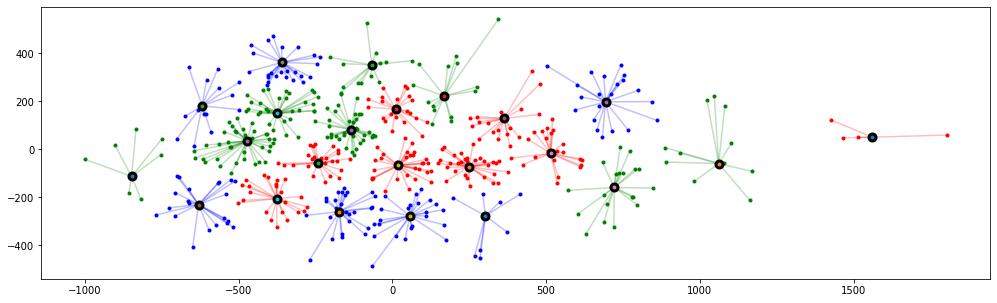

In [170]:
from itertools import cycle
import matplotlib.pyplot as plt

colors = cycle('rgb')
for k, col in zip(range(n_clusters_rs), colors):
    class_members = labels_rs == k
    cluster_center = x_500[cluster_centers_indices_rs[k]]
    plt.plot(x_500[class_members, 0], x_500[class_members, 1], col + '.')
    for x in x_500[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col, alpha=0.25)
    plt.plot(cluster_center[0], cluster_center[1], 'o', mec='k', mew=3, markersize=7)

plt.show()

In [171]:
# poly encoder data
cluster_center = [x_500[cluster_centers_indices_rs[k]] for k in range(n_clusters_rs)]

# track_id, value, cluster_label
cluster_data = []
for track_id, x, l in zip(x_track_id_500, x_500, labels_rs):
    cluster_data.append([track_id, x, l])
cluster_data = np.asarray(cluster_data)
cluster_data[:3]

/home/super/.pyenv/versions/3.8.0/envs/venv_py38/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


array([[25324, array([ -43.08845608, -312.62259068]), 8],
       [18034, array([150.20970131, -58.38226647]), 21],
       [72046, array([  15.47435007, -122.20634741]), 18]], dtype=object)

In [172]:
idx = random.sample(range(0,500),100)
cluster_rs = cluster_data[idx, :]
len(cluster_rs)
cluster_rs[:3]

array([[44850, array([ 536.16418468, -140.99917577]), 6],
       [113028, array([480.82081294, 273.72204435]), 15],
       [117611, array([730.82831942, 272.14072888]), 14]], dtype=object)

In [173]:
def distance(a, b):
    dist = np.sqrt(np.sum(np.square(a-b)))
    return dist

In [174]:
# poly_data = (now_track_id, true_track_id, false_track_id*9)
poly_data_set = []

for c in cluster_rs:
    poly_data = []
    poly_data.append(c[0]) # now track id
    
    # find top3 distance
    distance_list = []
    for track_id, x in zip(x_track_id_500, x_500):
        distance_list.append([track_id, distance(c[1], x)])
    
    distance_list = sorted(distance_list,key=lambda l:l[1])
    top3 = distance_list[1:4]# 자신 제외
    poly_data.append(top3[random.randint(0,2)][0])
    
    # select random false data (except self, top3, same cluster)
    false_list = []
    while len(false_list)<9:
        data = cluster_data[random.randint(0,499)]
        if data[0] != c[0] and data[2] != c[2]:
            if data[0] not in top3[:][0]:
                false_list.append(data[0])
            else:
                pass
        else:
            pass
    poly_data.extend(false_list)
    poly_data_set.append(poly_data)
print(poly_data_set[:3], len(poly_data_set))


[[44850, 38882, 123835, 108505, 64248, 53862, 10444, 56800, 47199, 131912, 91309], [113028, 10694, 144552, 85419, 54438, 121915, 67639, 142572, 144548, 129400, 123647], [117611, 126417, 98573, 40134, 64553, 138319, 115769, 114201, 129398, 80696, 28608]] 100


In [175]:
import csv
f = open('poly_data_set_10.csv','w', newline='')
wr = csv.writer(f)
for p in poly_data_set:
    wr.writerow(p)
f.close()